In [ ]:
from langchain.document_loaders import CSVLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.chains import RetrievalQA

In [2]:
loader = CSVLoader(file_path='/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv')

In [3]:
data = loader.load()

In [4]:
import cassio
## connection of the ASTRA DB
ASTRA_DB_APPLICATION_TOKEN="AstraCS:QapwRsiXCpRKErwvPUswwxmP:9b592a9710568433715878f69c3d4e05ebbce744e72fe7152e0d741671086602" # enter the "AstraCS:..." string found in in your Token JSON file"
ASTRA_DB_ID="8ae04c4a-3d4c-4cd7-959e-28fd1a167fbd"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="kural_demo",
    session=None,
    keyspace=None
)

/home/kundeshwar/miniconda3/envs/kuralGPT/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)

In [7]:
doc_splits = text_splitter.split_documents(data)

In [8]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="kural_demo",
    session=None,
    keyspace=None

)

In [9]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 1391 headlines.


In [11]:
retriever=astra_vector_store.as_retriever()
retriever.invoke("What is love?",ConsistencyLevel="LOCAL_ONE")

[Document(metadata={'row': '70.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content='kural: அன்பிற்கும் உண்டோ அடைக்குந்தாழ் ஆர்வலர்புன்கணீர் பூசல் தரும்.\nexplanation: Kural 71 explores the profound nature of love and affection. It asks rhetorically, "Can love ever be truly concealed or restrained?" implying that genuine love cannot be suppressed or hidden. The verse suggests that the true depth of one\'s affection for another often reveals itself when the loved one is in distress or suffering. This is symbolically represented by the shedding of tears. \n\nThe second line of the verse, "Tears of the affectionate will publish the love that is within", emphasizes that emotional reactions such as tears are a spontaneous and honest expression of the love concealed within one\'s heart. In other words, even though one might try to hide their feelings of love, their emotional reactions will inevitably reveal the truth. \n\nThis verse highlights the enduring a

In [14]:
documents=retriever.invoke("What is attachement?",ConsistencyLevel="LOCAL_ONE")


In [15]:
documents

[Document(metadata={'row': '1104.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content="Putting these together, the Kural essentially means that the sight of the beloved's flower-adorned arms brings as much joy and pleasure as fulfilling one's desires or wishes. It is a metaphorical expression of the intense pleasure one derives from the beauty and companionship of their beloved.\n\nTherefore, this verse is a beautiful expression of love and admiration, highlighting how the poet's beloved's beauty brings him immense joy and satisfaction, equating it to the joy of achieving one's desires.\ntranslation: The arms of my flower-tressed maid Whatever I wish that that accord"),
 Document(metadata={'row': '1104.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content="Putting these together, the Kural essentially means that the sight of the beloved's flower-adorned arms brings as much joy and pleasure as fulfilling one's desires or

In [16]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )
    
    


from langchain_ollama import ChatOllama


llm = ChatOllama(model="llama3.1")

structured_llm_router = llm.with_structured_output(RouteQuery)




# Prompt
system = """


   Consider yourself as assistant that take take question and content 
   then generate answer for the question based on the content and also used previous chat history 
   if needed just answer the last question.
   If there is no content ask clearification of the question, and last question you have to answer.


"""


route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "what is attachement?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

/home/kundeshwar/miniconda3/envs/kuralGPT/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


datasource='wiki_search'
datasource='wiki_search'


In [17]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)




api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [18]:
## Graph

from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [29]:


from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    
    
    
    answer=question_router.invoke({"question":question,
                            "context":documents
                            })
    print(answer)
    
    return {"documents": documents, "answer": answer}

In [46]:
documents[0].page_content 

"Putting these together, the Kural essentially means that the sight of the beloved's flower-adorned arms brings as much joy and pleasure as fulfilling one's desires or wishes. It is a metaphorical expression of the intense pleasure one derives from the beauty and companionship of their beloved.\n\nTherefore, this verse is a beautiful expression of love and admiration, highlighting how the poet's beloved's beauty brings him immense joy and satisfaction, equating it to the joy of achieving one's desires.\ntranslation: The arms of my flower-tressed maid Whatever I wish that that accord"

In [48]:
# question =f"What is love? Anser this question based on this context:{documents[0].page_content }"

# llm.invoke(
    
#     question
    
# )

AIMessage(content='What a lovely context!\n\nBased on this context, love is described as an intense pleasure derived from the beauty and companionship of one\'s beloved. It is a feeling of immense joy and satisfaction that brings happiness comparable to fulfilling one\'s desires or wishes.\n\nIn this poetic expression, love is not just a romantic emotion but also a source of delight, comfort, and contentment that surpasses other forms of pleasure. The sight of the beloved\'s beauty, as metaphorically represented by the "flower-adorned arms", has the power to bring as much joy as achieving one\'s deepest desires.\n\nThis definition highlights the all-encompassing nature of love, which can encompass not just romantic feelings but also a deep appreciation and admiration for the person loved.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-10-18T15:12:54.414292023Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 't

In [20]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [21]:
### Edges ###

def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    print(source)
    return "vectorstore"
    
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [22]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    print(source)
    return "vectorstore"
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [30]:

from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes

workflow.add_node("retrieve", retrieve)  # retrieve
# workflow.add_node("wiki_search", wiki_search)  # web search

# Build graph
workflow.add_edge(
    
    START,"retrieve"
)

# workflow.add_conditional_edges(
#     START,
#     route_question,
#     {
#         "vectorstore": "retrieve",
#         "wiki_search": "wiki_search"
        
#     },
# )
workflow.add_edge( "retrieve", END)
# workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

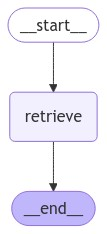

In [31]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
from pprint import pprint

# Run
inputs = {
    "question": "What is love?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")



---RETRIEVE---
datasource='wiki_search'
"Node 'retrieve':"
'\n---\n'


In [33]:
value

{'documents': [Document(metadata={'row': '70.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content='kural: அன்பிற்கும் உண்டோ அடைக்குந்தாழ் ஆர்வலர்புன்கணீர் பூசல் தரும்.\nexplanation: Kural 71 explores the profound nature of love and affection. It asks rhetorically, "Can love ever be truly concealed or restrained?" implying that genuine love cannot be suppressed or hidden. The verse suggests that the true depth of one\'s affection for another often reveals itself when the loved one is in distress or suffering. This is symbolically represented by the shedding of tears. \n\nThe second line of the verse, "Tears of the affectionate will publish the love that is within", emphasizes that emotional reactions such as tears are a spontaneous and honest expression of the love concealed within one\'s heart. In other words, even though one might try to hide their feelings of love, their emotional reactions will inevitably reveal the truth. \n\nThis verse highlights 

In [34]:
app.invoke({"question":"What is Love?"})

---RETRIEVE---
datasource='wiki_search'


{'question': 'What is Love?',
 'documents': [Document(metadata={'row': '70.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content='kural: அன்பிற்கும் உண்டோ அடைக்குந்தாழ் ஆர்வலர்புன்கணீர் பூசல் தரும்.\nexplanation: Kural 71 explores the profound nature of love and affection. It asks rhetorically, "Can love ever be truly concealed or restrained?" implying that genuine love cannot be suppressed or hidden. The verse suggests that the true depth of one\'s affection for another often reveals itself when the loved one is in distress or suffering. This is symbolically represented by the shedding of tears. \n\nThe second line of the verse, "Tears of the affectionate will publish the love that is within", emphasizes that emotional reactions such as tears are a spontaneous and honest expression of the love concealed within one\'s heart. In other words, even though one might try to hide their feelings of love, their emotional reactions will inevitably reveal the tru

In [34]:
from pprint import pprint

# Run
inputs = {
    "question": "What is love?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
[Document(metadata={'row': '70.0', 'source': '/nfs/kundeshwar/surajKuralGPT/langGraph/thirukkural.csv'}, page_content='kural: அன்பிற்கும் உண்டோ அடைக்குந்தாழ் ஆர்வலர்புன்கணீர் பூசல் தரும்.\nexplanation: Kural 71 explores the profound nature of love and affection. It asks rhetorically, "Can love ever be truly concealed or restrained?" implying that genuine love cannot be suppressed or hidden. The verse suggests that the true depth of one\'s affection for another often reveals itself when the loved one is in distress or suffering. This is symbolically represented by the shedding of tears. \n\nThe second line of the verse, "Tears of the affectionate will publish the love that is within", emphasizes that emotional reactions such as tears are a spontaneous and honest expression of the love concealed within one\'s heart. In other words, even though one might try to hide their feelings of love, their emotional reactions will inev